# _Set Up and Data Processing_

In [63]:
from capstone import data
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [64]:
torch.cuda.empty_cache()

In [65]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [66]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

In [5]:
# take 5% of data with a different seed than previous trail11
train_df, valid_df = data.data_processing(path, 'Atelectasis', 8, 0.05);

(223414, 19)
(234, 19)
Extracted Patient ID from Path column and created new column named Patient_id
Created function named seed_data to set seed for sample data
Seeded data.
Created sample dataframe with input seed.
Created training and validation dataframe with expressed competition task, replacing NaN's with 0 and resetting the index
Atelectasis
Training shape
(11071, 2)

Validation shape
(234, 2)


In [6]:
train_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00006/study1/...,0.0
1,CheXpert-v1.0-small/train/patient00031/study1/...,-1.0
2,CheXpert-v1.0-small/train/patient00031/study3/...,0.0
3,CheXpert-v1.0-small/train/patient00031/study2/...,1.0
4,CheXpert-v1.0-small/train/patient00044/study7/...,-1.0


In [7]:
valid_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/valid/patient64541/study1/...,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,0.0


# _U-Ignore_: Drop Uncertain (-1) Labels

In [8]:
train_df = train_df[train_df['Atelectasis'] != -1].reset_index(drop=True)
train_df['Atelectasis'] = train_df['Atelectasis'].astype(int)

In [9]:
train_df.head(10)

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00006/study1/...,0
1,CheXpert-v1.0-small/train/patient00031/study3/...,0
2,CheXpert-v1.0-small/train/patient00031/study2/...,1
3,CheXpert-v1.0-small/train/patient00044/study6/...,1
4,CheXpert-v1.0-small/train/patient00044/study6/...,1
5,CheXpert-v1.0-small/train/patient00044/study2/...,1
6,CheXpert-v1.0-small/train/patient00044/study3/...,0
7,CheXpert-v1.0-small/train/patient00044/study1/...,1
8,CheXpert-v1.0-small/train/patient00044/study4/...,0
9,CheXpert-v1.0-small/train/patient00049/study1/...,0


In [10]:
train_df.shape

(9416, 2)

# Set Up For DL Training

In [11]:
# default transformations
tfms = get_transforms()

In [12]:
src = (ImageList.from_df(df=train_df, path=path, folder='.', suffix=''))

In [13]:
src = src.split_by_rand_pct(0.1)

In [15]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=32
else:           
    bs=16
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=16, have 7601MB of GPU RAM free


In [16]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=224)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [17]:
print(data.c)
print(data.classes)

2
[0, 1]


In [79]:
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])

In [23]:
learn12 = cnn_learner(data=data, base_arch=models.resnet101, metrics=accuracy, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/jupyter/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:09<00:00, 18749302.93it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.80E-02
Min loss divided by 10: 4.68E-03


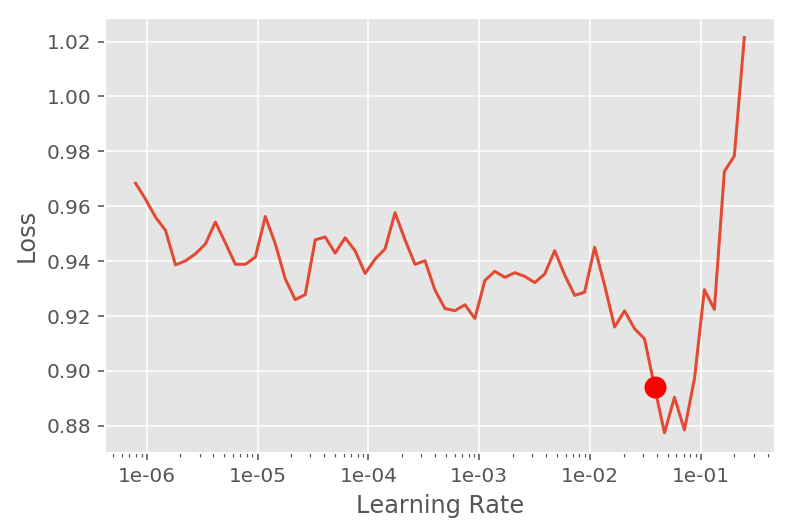

In [24]:
learn12.lr_find(start_lr=1e-7, end_lr=100)
learn12.recorder.plot(suggestion=True)

In [25]:
lr = learn12.recorder.min_grad_lr
lr

0.03801893963205612

# _Rd 1 Training_

In [26]:
learn12.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.632117,0.473916,0.840595,02:23
1,0.522055,0.441756,0.840595,02:19
2,0.472960,0.444127,0.840595,02:19
3,0.479490,0.433385,0.840595,02:18


In [28]:
interp = ClassificationInterpretation.from_learner(learn12)

In [29]:
losses, idxs = interp.top_losses()

In [30]:
len(data.valid_ds) == len(losses) == len(idxs)

True

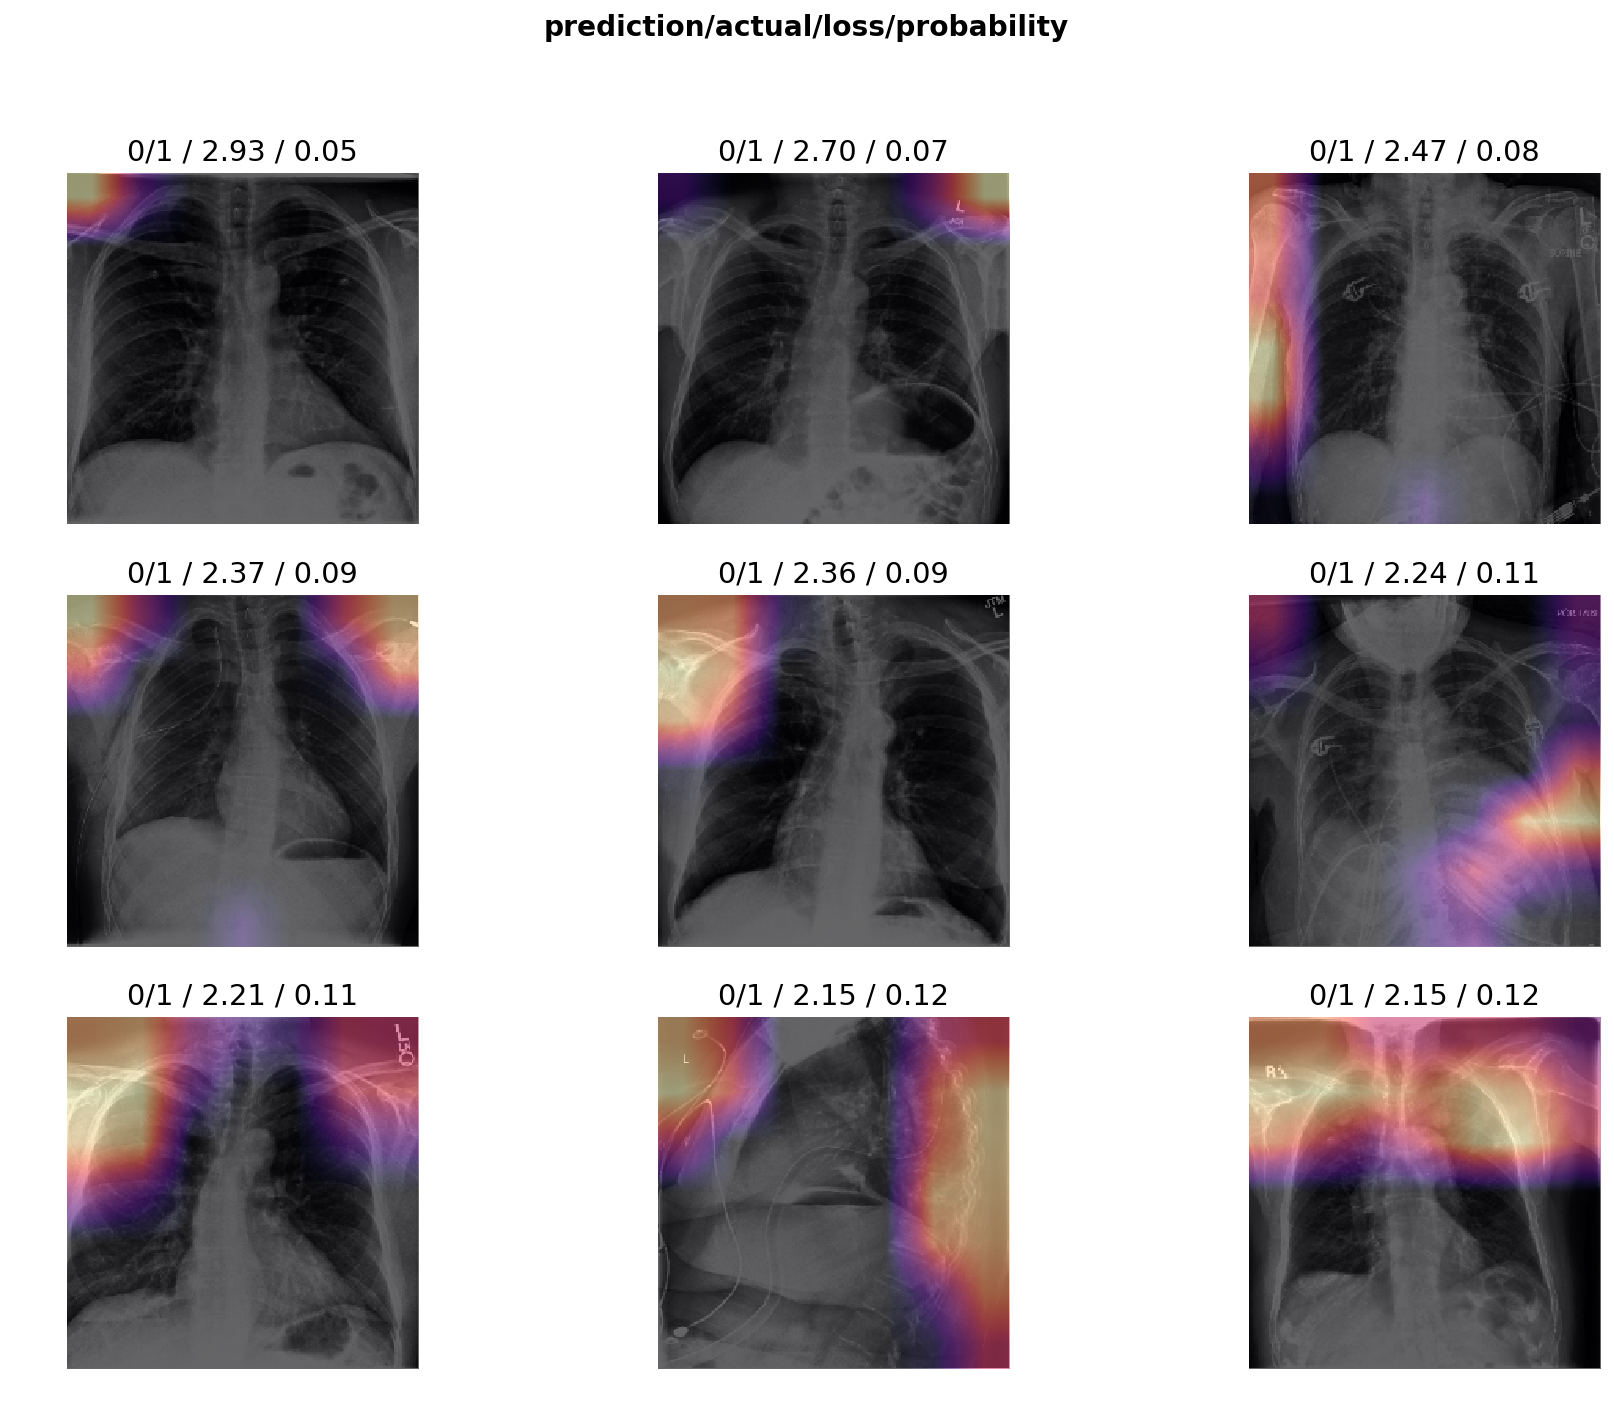

In [31]:
interp.plot_top_losses(9, figsize=(15,11))

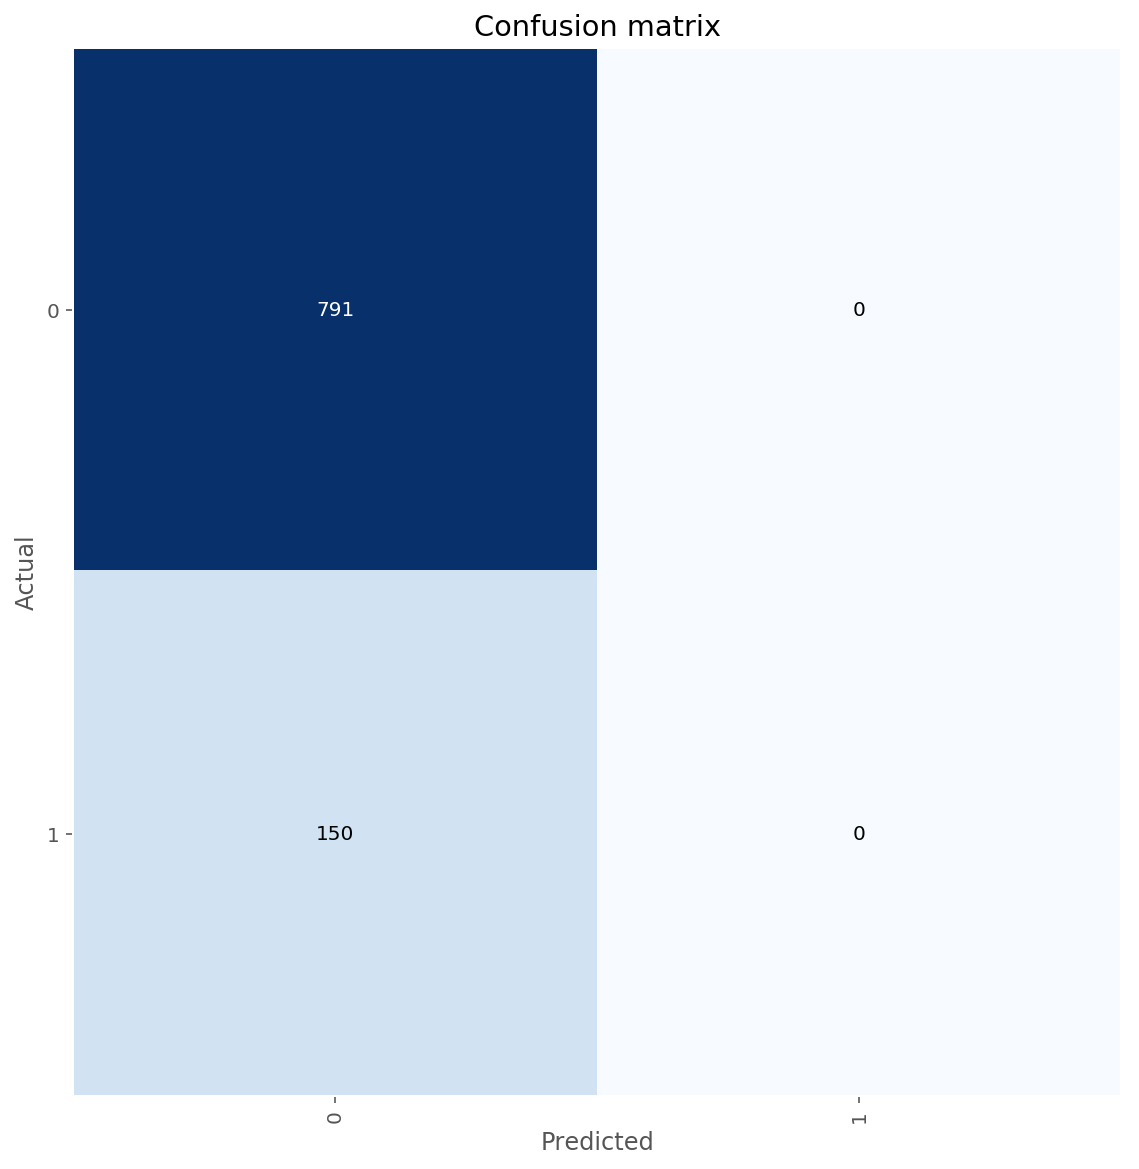

In [33]:
interp.plot_confusion_matrix(figsize=(8,8))

In [35]:
learn12.save('trial12-rd-1-resnet101')

# _Reconstructing data and launching -- Rd. 2 Training_

In [36]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_rotate=359,
                     max_zoom=1.05, max_warp=0.1)

In [37]:
src = (ImageList.from_df(df=train_df, path=path, folder='.', suffix=''))

In [38]:
src = src.split_by_rand_pct(0.1)

In [39]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=224)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [80]:
learn12 = cnn_learner(data=data, base_arch=models.resnet101, metrics=accuracy, pretrained=True, callback_fns=AUROC)

AttributeError: module 'capstone.data' has no attribute 'c'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.82E-06
Min loss divided by 10: 3.16E-04


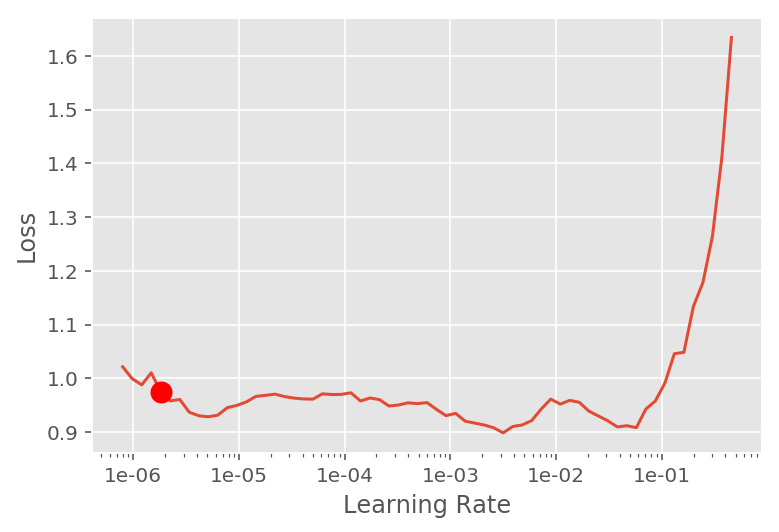

In [41]:
learn12.lr_find(start_lr=1e-7, end_lr=100)
learn12.recorder.plot(suggestion=True)

In [42]:
lr = 1e-03
learn12.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.562381,0.571253,0.759830,0.507419,02:21
1,0.479430,0.488116,0.822529,0.516455,02:22
2,0.475096,0.467476,0.822529,0.555254,02:22
3,0.473794,0.461080,0.822529,0.577156,02:22
4,0.439614,0.461270,0.822529,0.594872,02:22


In [43]:
learn12.save('learn12-rd2-rn101')

# _Unfreezing, fine-tuning, and learning rates_

In [44]:
# load previous weights
learn12.load('learn12-rd2-rn101');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-05
Min loss divided by 10: 1.20E-07


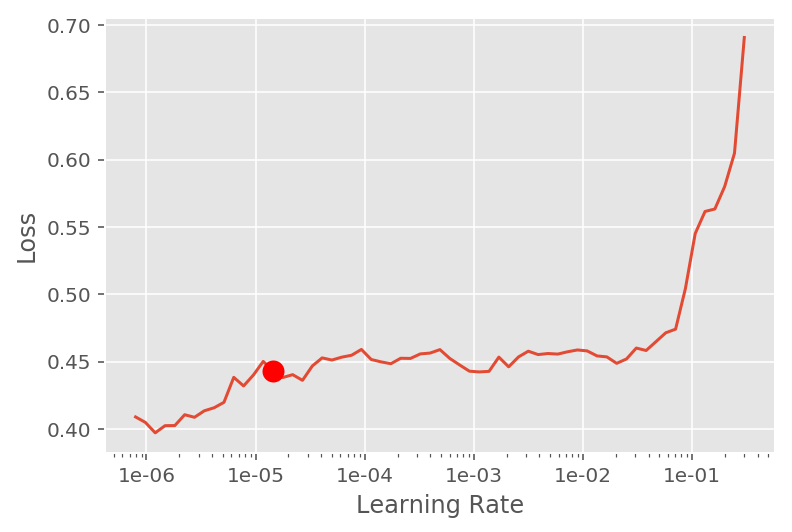

In [45]:
learn12.lr_find(start_lr=1e-7, end_lr=100)
learn12.recorder.plot(suggestion=True)

In [46]:
# unfreeze the model allowing pretrained weights to move around
learn12.unfreeze()

# lower layers change weights more slowly than higher layers
learn12.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.426796,0.472757,0.822529,0.593944,03:19
1,0.446563,0.459318,0.822529,0.602299,03:18


In [47]:
learn12.save('learn12-rd3-rn101')

# _New Data Set (train-df2)_

In [68]:
from capstone import data
# take 5% of data with a different seed than previous trail11
train_df2, valid_df2 = data.data_processing(path, 'Atelectasis', 101, 0.05);

(223414, 19)
(234, 19)
Extracted Patient ID from Path column and created new column named Patient_id
Created function named seed_data to set seed for sample data
Seeded data.
Created sample dataframe with input seed.
Created training and validation dataframe with expressed competition task, replacing NaN's with 0 and resetting the index
Atelectasis
Training shape
(10818, 2)

Validation shape
(234, 2)


In [69]:
train_df2 = train_df2[train_df2['Atelectasis'] != -1].reset_index(drop=True)
train_df2['Atelectasis'] = train_df2['Atelectasis'].astype(int)

In [70]:
train_df2.head(10)

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00003/study1/...,0
1,CheXpert-v1.0-small/train/patient00023/study1/...,0
2,CheXpert-v1.0-small/train/patient00023/study1/...,0
3,CheXpert-v1.0-small/train/patient00023/study4/...,0
4,CheXpert-v1.0-small/train/patient00023/study4/...,0
5,CheXpert-v1.0-small/train/patient00023/study11...,0
6,CheXpert-v1.0-small/train/patient00023/study11...,0
7,CheXpert-v1.0-small/train/patient00023/study2/...,0
8,CheXpert-v1.0-small/train/patient00023/study2/...,0
9,CheXpert-v1.0-small/train/patient00023/study10...,0


In [71]:
train_df2.shape

(9200, 2)

# _Set Up For DL Training (w/ new train-df2)_

In [72]:
src2 = (ImageList.from_df(df=train_df2, path=path, folder='.', suffix=''))

In [73]:
src2 = src2.split_by_rand_pct(0.1)

In [74]:
data2 = (src2.label_from_df(cols='Atelectasis')
        .transform(tfms, size=224)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [75]:
data2.c

2

In [76]:
data2.classes

[0, 1]

In [77]:
learn12.data = data2

# _Rd. 4 Training w/ new data_

In [78]:
learn12.load('learn12-rd3-rn101');

PicklingError: Can't pickle <class '__main__.AUROC'>: it's not the same object as __main__.AUROC

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.19E-05
Min loss divided by 10: 1.74E-05


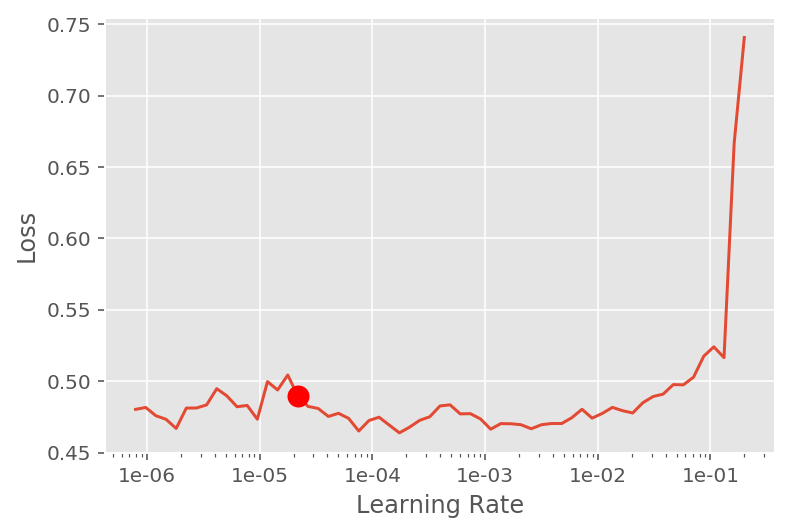

In [61]:
learn12.lr_find(start_lr=1e-7, end_lr=100)
learn12.recorder.plot(suggestion=True)

In [62]:
learn12.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.492853,0.757069,0.827174,0.450248,03:16
1,0.487057,0.466732,0.827174,0.508186,03:13
2,0.483177,0.483544,0.827174,0.563492,03:12
3,0.476101,0.456494,0.827174,0.599848,03:12
